# US Stock Market Prediction using Tree Based Algirithms with a Window Function

In [1]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
import lightgbm as lgb

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [2]:
# Reading the dataset
dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
# Rename the first column
df = df.rename(columns={df.columns[0]: 'date_index'})
print(df.columns)

df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.','Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.']]
df['prev_index'] = df['date_index'] + 1
df.head(5)

Index(['date_index', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')


,date_index,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,prev_index
0,0,2.079,NaN,72.28,NaN,3.8215,NaN,1
1,1,2.050,161340.0,73.82,577940.0,3.8535,NaN,2
2,2,2.100,142860.0,75.85,344490.0,3.9060,NaN,3
3,3,2.077,139750.0,77.82,347240.0,3.9110,NaN,4
4,4,2.490,3590.0,76.78,331930.0,3.8790,NaN,5


In [3]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [4]:
window_back = 10

for i in range (0,window_back,1):
    prev_df = get_prev_pane(df,i,'date_index')
    if i == 0:
        final_df = prev_df
    else:
        final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)
    
final_df = final_df.iloc[:-window_back]
final_df

,Natural_Gas_Price_0,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Copper_Vol._0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Crude_oil_Price_1,Crude_oil_Vol._1,...,Crude_oil_Price_8,Crude_oil_Vol._8,Copper_Price_8,Copper_Vol._8,Natural_Gas_Price_9,Natural_Gas_Vol._9,Crude_oil_Price_9,Crude_oil_Vol._9,Copper_Price_9,Copper_Vol._9
0,2.079,NaN,72.28,NaN,3.8215,NaN,2.050,161340.0,73.82,577940.0,...,74.37,306060.0,3.7935,NaN,2.419,121580.0,75.19,28910.0,3.7635,NaN
1,2.050,161340.0,73.82,577940.0,3.8535,NaN,2.100,142860.0,75.85,344490.0,...,75.19,28910.0,3.7635,NaN,2.519,138430.0,73.41,78230.0,3.7865,NaN
2,2.100,142860.0,75.85,344490.0,3.9060,NaN,2.077,139750.0,77.82,347240.0,...,73.41,78230.0,3.7865,NaN,2.697,151820.0,74.08,86650.0,3.7450,NaN
3,2.077,139750.0,77.82,347240.0,3.9110,NaN,2.490,3590.0,76.78,331930.0,...,74.08,86650.0,3.7450,NaN,2.870,150330.0,72.56,315680.0,3.7330,NaN
4,2.490,3590.0,76.78,331930.0,3.8790,NaN,2.712,73020.0,78.01,365460.0,...,72.56,315680.0,3.7330,NaN,2.900,228160.0,72.40,430440.0,3.7665,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1.861,195460.0,50.75,887950.0,2.5785,370.0,1.872,184040.0,49.61,859360.0,...,54.19,586200.0,2.6840,72570.0,1.926,179790.0,55.59,704000.0,2.7260,88850.0
990,1.872,184040.0,49.61,859360.0,2.5455,650.0,1.819,163790.0,50.11,876040.0,...,55.59,704000.0,2.7260,88850.0,1.905,240000.0,56.74,620120.0,2.7650,71190.0
991,1.819,163790.0,50.11,876040.0,2.5105,540.0,1.841,135680.0,51.56,827910.0,...,56.74,620120.0,2.7650,71190.0,1.895,255720.0,58.34,50180.0,2.7935,103870.0
992,1.841,135680.0,51.56,827910.0,2.5200,470.0,1.829,219700.0,52.14,720120.0,...,58.34,50180.0,2.7935,103870.0,2.003,213280.0,58.54,122560.0,2.8455,59520.0


In [5]:
col_names = final_df.columns[1:].tolist()
print(col_names)

# creating a copy of df
df1 = final_df.fillna(0)

#target column name
label_name = 'Natural_Gas_Price_0'


# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[col_names] = scaler.fit_transform(X[col_names])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

['Natural_Gas_Vol._0', 'Crude_oil_Price_0', 'Crude_oil_Vol._0', 'Copper_Price_0', 'Copper_Vol._0', 'Natural_Gas_Price_1', 'Natural_Gas_Vol._1', 'Crude_oil_Price_1', 'Crude_oil_Vol._1', 'Copper_Price_1', 'Copper_Vol._1', 'Natural_Gas_Price_2', 'Natural_Gas_Vol._2', 'Crude_oil_Price_2', 'Crude_oil_Vol._2', 'Copper_Price_2', 'Copper_Vol._2', 'Natural_Gas_Price_3', 'Natural_Gas_Vol._3', 'Crude_oil_Price_3', 'Crude_oil_Vol._3', 'Copper_Price_3', 'Copper_Vol._3', 'Natural_Gas_Price_4', 'Natural_Gas_Vol._4', 'Crude_oil_Price_4', 'Crude_oil_Vol._4', 'Copper_Price_4', 'Copper_Vol._4', 'Natural_Gas_Price_5', 'Natural_Gas_Vol._5', 'Crude_oil_Price_5', 'Crude_oil_Vol._5', 'Copper_Price_5', 'Copper_Vol._5', 'Natural_Gas_Price_6', 'Natural_Gas_Vol._6', 'Crude_oil_Price_6', 'Crude_oil_Vol._6', 'Copper_Price_6', 'Copper_Vol._6', 'Natural_Gas_Price_7', 'Natural_Gas_Vol._7', 'Crude_oil_Price_7', 'Crude_oil_Vol._7', 'Copper_Price_7', 'Copper_Vol._7', 'Natural_Gas_Price_8', 'Natural_Gas_Vol._8', 'Crude_oi

,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Copper_Vol._0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Crude_oil_Price_1,Crude_oil_Vol._1,Copper_Price_1,...,Crude_oil_Price_8,Crude_oil_Vol._8,Copper_Price_8,Copper_Vol._8,Natural_Gas_Price_9,Natural_Gas_Vol._9,Crude_oil_Price_9,Crude_oil_Vol._9,Copper_Price_9,Copper_Vol._9
0,-1.649602,-0.029939,-2.287147,0.008426,-0.140812,-0.357806,0.483326,0.023041,1.587122,0.049643,...,0.047417,-0.233706,-0.011043,-0.17292,-0.201727,-0.048228,0.075969,-2.052233,-0.046754,-0.188406
1,0.483326,0.023362,1.590734,0.048369,-0.140812,-0.336709,0.239019,0.092337,0.022156,0.114800,...,0.075289,-2.063411,-0.046859,-0.17292,-0.159613,0.173804,0.015466,-1.728393,-0.019357,-0.188406
2,0.239019,0.093623,0.024323,0.113902,-0.140812,-0.346414,0.197905,0.159584,0.040591,0.121005,...,0.014786,-1.737807,-0.019400,-0.17292,-0.084649,0.350244,0.038239,-1.673107,-0.068791,-0.188406
3,0.197905,0.161807,0.042775,0.120144,-0.140812,-0.172152,-1.602142,0.124083,-0.062042,0.081291,...,0.037559,-1.682220,-0.068945,-0.17292,-0.011792,0.330610,-0.013426,-0.169274,-0.083085,-0.188406
4,-1.602142,0.125811,-0.059952,0.080200,-0.140812,-0.078481,-0.684271,0.166069,0.162731,0.047782,...,-0.014106,-0.170196,-0.083271,-0.17292,0.000842,1.356173,-0.018865,0.584251,-0.043180,-0.188406


In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [7]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
}

AdaBoostRegressor CV Scores: [-0.11167124 -0.06050239 -0.05787271 -0.07149715 -0.06318327]
AdaBoostRegressor Mean Squared Error (MSE): 0.07396154990818125
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.2719587283177013
AdaBoostRegressor Mean Absolute Error (MAE): 0.20279214756196373
AdaBoostRegressor R^2 Score: 0.9821003023319769


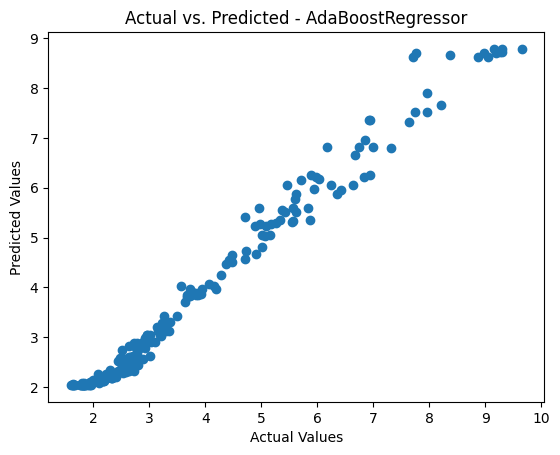

LinearRegression CV Scores: [-0.08166252 -0.0358363  -0.03581677 -0.06371987 -0.04343748]
LinearRegression Mean Squared Error (MSE): 0.046914107299959464
LinearRegression Root Mean Squared Error (RMSE): 0.2165966465575113
LinearRegression Mean Absolute Error (MAE): 0.1535341233529788
LinearRegression R^2 Score: 0.9886461500864034


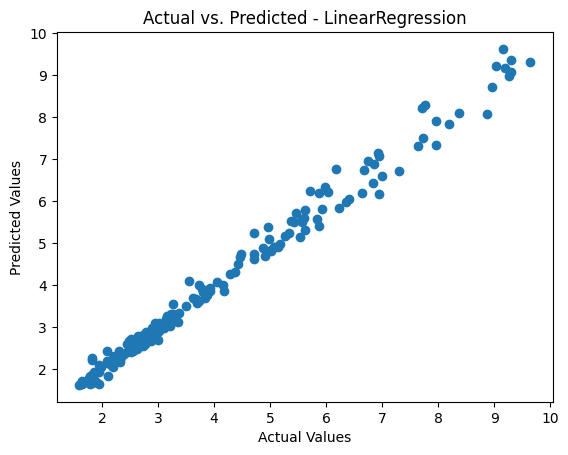

KNeighborsRegressor CV Scores: [-0.24766898 -0.22589201 -0.17895594 -0.17578899 -0.23144891]
KNeighborsRegressor Mean Squared Error (MSE): 0.22544652864321613
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.4748120982485768
KNeighborsRegressor Mean Absolute Error (MAE): 0.3500562814070352
KNeighborsRegressor R^2 Score: 0.9454388840143478


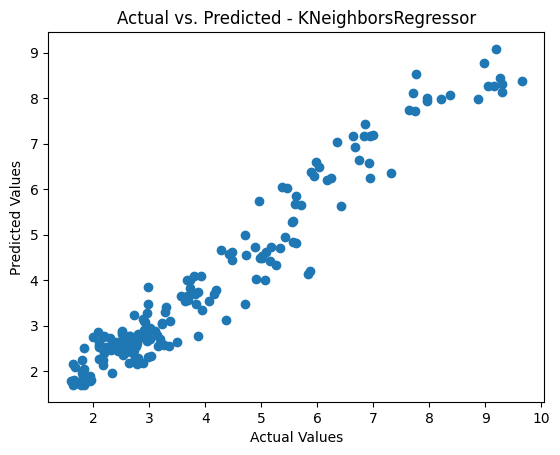

RandomForestRegressor CV Scores: [-0.09136084 -0.04363532 -0.04343462 -0.05094656 -0.05036957]
RandomForestRegressor Mean Squared Error (MSE): 0.04717190394974872
RandomForestRegressor Root Mean Squared Error (RMSE): 0.21719093892183605
RandomForestRegressor Mean Absolute Error (MAE): 0.14766311557788941
RandomForestRegressor R^2 Score: 0.9885837598025764


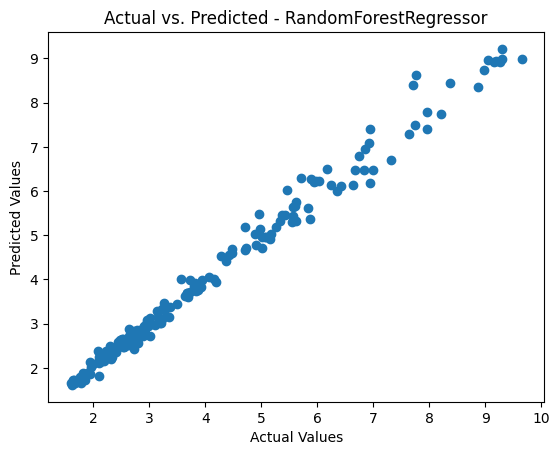

GradientBoostingRegressor CV Scores: [-0.12281876 -0.0769061  -0.08737211 -0.08123548 -0.06656359]
GradientBoostingRegressor Mean Squared Error (MSE): 0.07592923951900639
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.27555260753439875
GradientBoostingRegressor Mean Absolute Error (MAE): 0.19896098897424364
GradientBoostingRegressor R^2 Score: 0.9816240947730223


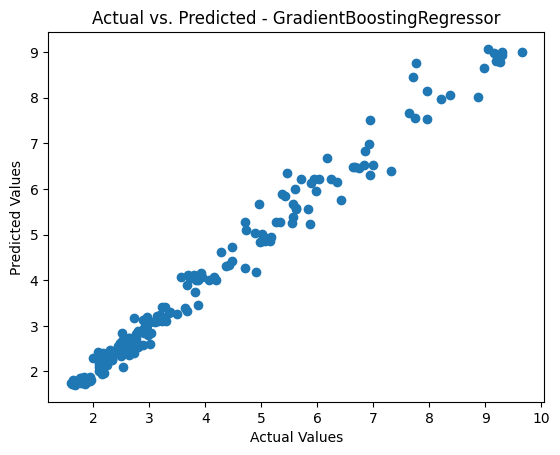

XGBRegressor CV Scores: [-0.10395228 -0.06734807 -0.04267677 -0.05954724 -0.05230017]
XGBRegressor Mean Squared Error (MSE): 0.04804896921542785
XGBRegressor Root Mean Squared Error (RMSE): 0.21920075094631372
XGBRegressor Mean Absolute Error (MAE): 0.14649160696154268
XGBRegressor R^2 Score: 0.9883714981191711


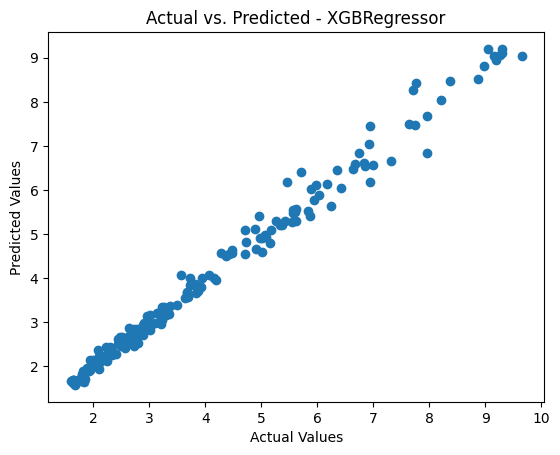

In [8]:
# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


## Model Results
- MSE is the one that we will use as MSE penalizes larger errors more heavily, which can be important in financial forecasting where large errors may have significant consequences.

In [9]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.073962,0.271959,0.202792,0.982100,"[-0.11167124088647838, -0.06050239216340707, -..."
1,LinearRegression,0.046914,0.216597,0.153534,0.988646,"[-0.081662521302536, -0.03583629641837742, -0...."
2,KNeighborsRegressor,0.225447,0.474812,0.350056,0.945439,"[-0.24766897509433958, -0.22589201056603778, -..."
3,RandomForestRegressor,0.047172,0.217191,0.147663,0.988584,"[-0.09136084264150938, -0.0436353192339623, -0..."
4,GradientBoostingRegressor,0.075929,0.275553,0.198961,0.981624,"[-0.12281876356737242, -0.07690609894966018, -..."
5,XGBRegressor,0.048049,0.219201,0.146492,0.988371,"[-0.10395228294756478, -0.06734807100087388, -..."


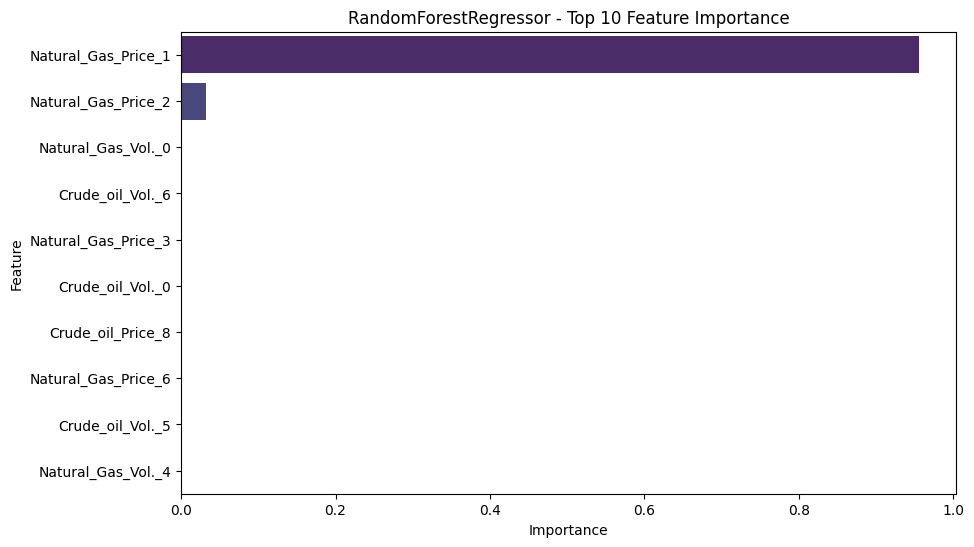

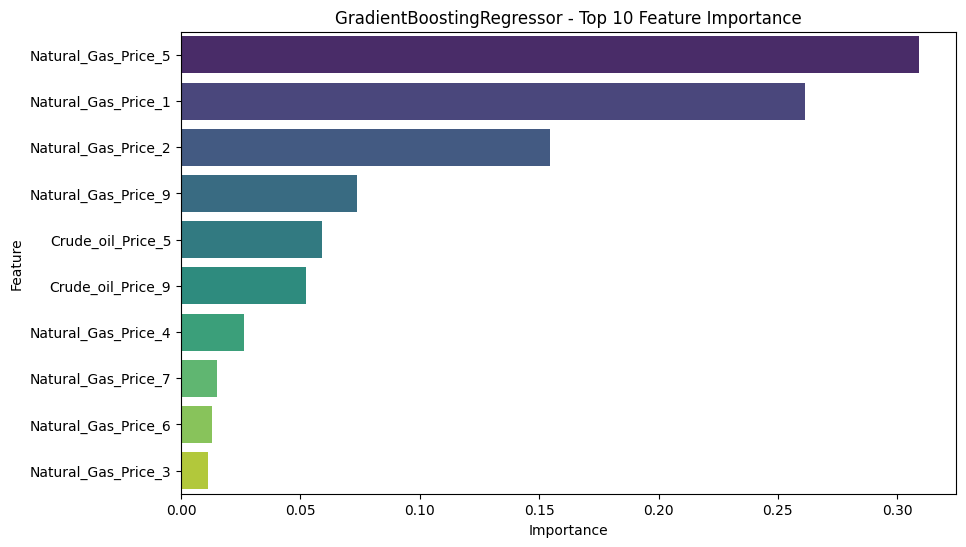

In [10]:
import seaborn as sns

# Feature importance for tree-based models
for name, model in regressors.items():
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        sorted_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Display only the top 10 features
        top_10_features = sorted_df.head(10)
        
        # Create seaborn bar plot for the top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
        plt.title(f"{name} - Top 10 Feature Importance")
        plt.show()


In [11]:
# instantiating the object
model = RandomForestRegressor()

# setting a grid - not so extensive
parameters = {'n_estimators': [50, 60],
    'max_depth': [2,3,10,15,20,25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# instantiating the GridSearchCV object
# For binary classification:
# 'accuracy': Calculates the accuracy of the classifier.
# 'precision': Measures the ability of the classifier not to label as positive a sample that is negative.
# 'recall': Measures the ability of the classifier to capture all the positive samples.
# 'f1': Combines precision and recall into a single metric.
# 'roc_auc': Computes the area under the Receiver Operating Characteristic (ROC) curve.

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5,  scoring='neg_mean_squared_error')

# fitting the object
searcher.fit(X_train, y_train)

# the scores
print("The best params are :", searcher.best_params_)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# Printing the test mean squared error
mse = mean_squared_error(y_test, y_pred)
print("The test mean squared error of the model after hyper-parameter tuning is", mse)

The best params are : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 60}
The best score is   : -0.05279496076970906
The test mean squared error of the model after hyper-parameter tuning is 0.0491229561353221


In [12]:
# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

callbacks = [lgb.early_stopping(50)]
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

try:
    # Try using GPU
    params['device'] = 'gpu'    
    bst = lgb.train(params, train_data, valid_sets=[test_data], callbacks=callbacks)
except lgb.basic.LightGBMError as e:
    # GPU training not supported, fall back to CPU
    del params['device']
    bst = lgb.train(params, train_data, valid_sets=[test_data], callbacks=callbacks)

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

 # Evaluation metrics for regression
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})

print("=============================================================================")
print(name, "CV Scores:", cv_scores)
print(name, "Mean Squared Error (MSE):", mse)
print(name, "Root Mean Squared Error (RMSE):", rmse)
print(name, "Mean Absolute Error (MAE):", mae)
print(name, "R^2 Score:", r2)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 795, number of used features: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 795, number of used features: 59
[LightGBM] [Info] Start training from score 3.718677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [13]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)